# Proyecto 4: Sentiment Analysis - Classification
----
University : UTEC \
Course       : Machine Learning \
Professor    : Cristian López Del Alamo 

----
Integrantes:
- Integrante 1: Marcelo Andres Chincha León
- Integrante 2: Alvaro Aaron Herrera Leiva
- Integrante 3: Adrian Joshep Cespedes Zevallos
- Integrante 4: Jeremy Lujan Arias
----

In [88]:
# configs
TEST_SIZE = 0.2
P_SEED = 2024

W2V_WORDS = 150
CQ_CHARS = 1500

# 1. Preparación y analisis de datos

## Instalar y cargar librerias

In [42]:
# %pip install numpy
# %pip install matplotlib
# %pip install scipy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install nltk
# %pip install gensim

In [43]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [44]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import torch
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import scipy
import gensim

np.random.seed(P_SEED)

## Cargar datos

In [45]:
df_train = pd.read_csv("data/train.csv")
df_submit = pd.read_csv("data/test.csv")
df_train.describe()

,message,label
count,25000,25000
unique,24904,2
top,How has this piece of crap stayed on TV this l...,neg
freq,3,12500


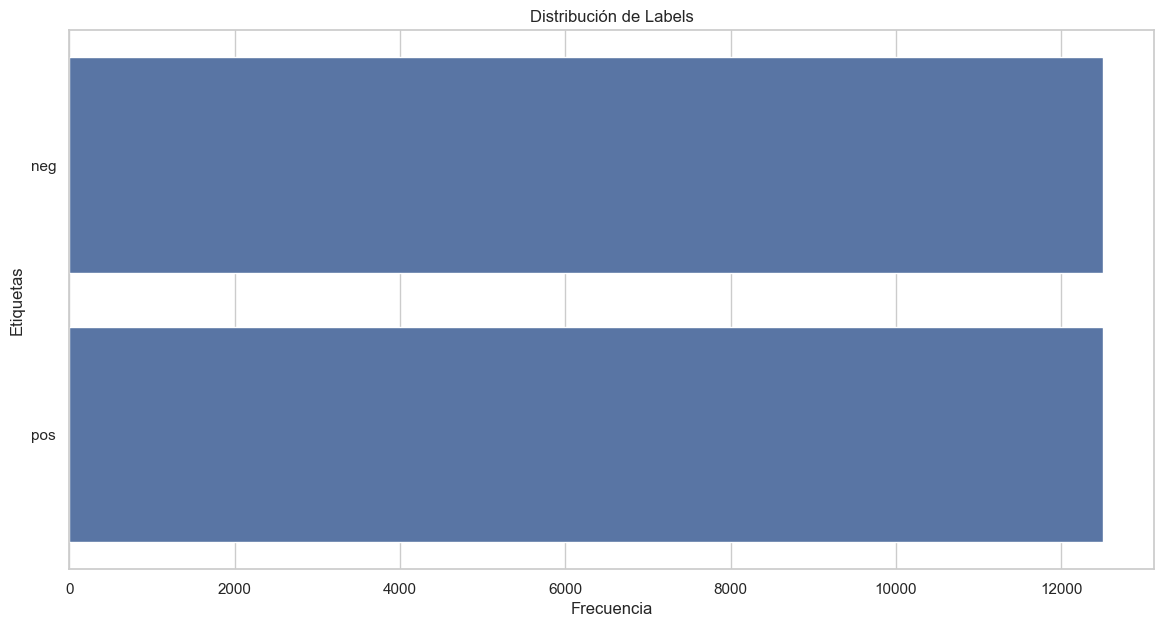

In [46]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(df_train.iloc[:, 1], order=df_train.iloc[:, 1].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Labels')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

----
# 2. Preprocesamiento

## TF-IDF

### Tokenizar, eliminar stopwords y Part-Of-Speech tag

In [89]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Lista de palabras de negación sintáctica
syntactic_negations = set(["no", "not", "none", "never", "neither", "nor", "cannot", "can't"])

# Lista de prefijos de negación morfológica
morphological_prefixes = ["un", "in", "dis", "im", "ir", "non", "anti"]

def tokenize(text):
    # return [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return [word for word in word_tokenize(text.lower()) if word.isalpha()]

def pos_tagging(tokens):
    return pos_tag(tokens)

# Función para convertir etiquetas de POS de NLTK a etiquetas de WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def mark_negations(tokens):
    # Marca las palabras y frases con negaciones.
    negated_tokens = []
    negation = False
    for token in tokens:
        if token in syntactic_negations:
            negation = True
            negated_tokens.append(token)
        elif negation:
            if token in stop_words:
                negated_tokens.append(token)
            else:
                negated_tokens.append(token + "_NEG")
                negation = False
        else:
            negated_tokens.append(token)
    
    return negated_tokens

# def mark_negations(tokens):
#     negated_tokens = []
#     negation = False
#     for i, token in enumerate(tokens):
#         if token in syntactic_negations:
#             negation = True
#             negated_tokens.append(token)
#         elif negation:
#             if token in stop_words:
#                 negated_tokens.append(token)
#             else:
#                 negated_tokens.append(token + "_NEG")
#                 # Detectar doble negación
#                 if i > 0 and tokens[i - 1] == "not":
#                     negated_tokens[i] = tokens[i]
#                 negation = False
#         else:
#             negated_tokens.append(token)
    
#     return negated_tokens


def handle_morphological_negations(tokens):
    # Marca las palabras con prefijos de negación morfológica.
    negated_tokens = []
    for token in tokens:
        for prefix in morphological_prefixes:
            if token.startswith(prefix):
                root = token[len(prefix):]
                negated_tokens.append(root + "_NEG")
                break
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def handle_double_negations(tokens):
    negated_tokens = []
    for i, token in enumerate(tokens):
        if token.endswith("_NEG_NEG"):
            negated_tokens.append(token[:-8])
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def lemmatize(pos_tags):
    return [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos) or wordnet.NOUN) for word, pos in pos_tags]

def preprocess(df):
    df['tokens'] = df['message'].apply(tokenize)
    df['tokens'] = df['tokens'].apply(mark_negations)
    df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['tokens'] = df['tokens'].apply(handle_morphological_negations)
    df['tokens'] = df['tokens'].apply(handle_double_negations)
    df['pos_tags'] = df['tokens'].apply(pos_tagging)
    df['lemmas'] = df['pos_tags'].apply(lemmatize)
    return df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [90]:
# Ejemplo de uso
import pandas as pd

data = {'message': ["The audience disliked the actor leading the play.", 
                    "He was not supposed to come.", 
                    "The price of the car is not insignificant."]}

df = pd.DataFrame(data)
processed_df = preprocess(df)

processed_df[['message', 'tokens', 'lemmas']]

,message,tokens,lemmas
0,The audience disliked the actor leading the play.,"[audience, liked_NEG, actor, leading, play]","[audience, liked_NEG, actor, lead, play]"
1,He was not supposed to come.,"[supposed_NEG, come]","[supposed_NEG, come]"
2,The price of the car is not insignificant.,"[price, car, significant]","[price, car, significant]"


In [91]:
df_train_tf = preprocess(df_train)
df_submit_tf = preprocess(df_submit)
df_train_tf.to_pickle('df_train_processed.pkl')
df_submit_tf.to_pickle('df_test_processed.pkl')

KeyboardInterrupt: 

### Cargar data una vez preprocesada

In [ ]:
df_train_tf = pd.read_pickle('df_train_processed.pkl')
df_submit_tf = pd.read_pickle('df_test_processed.pkl')

In [ ]:
from sklearn.model_selection import train_test_split
df_train_tf, df_test_tf = train_test_split(df_train_tf, test_size=TEST_SIZE, random_state=P_SEED)

In [ ]:
# use tf-idf to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=1000)
tfidf = TfidfVectorizer()

x_train_tf = tfidf.fit_transform(df_train_tf['lemmas'].apply(' '.join))
x_test_tf = tfidf.transform(df_test_tf['lemmas'].apply(' '.join))
x_submit_tf = tfidf.transform(df_submit_tf['lemmas'].apply(' '.join))

In [ ]:
#enconde de y a valores numericos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_tf = label_encoder.fit_transform(df_train_tf['label'])
y_test_tf = label_encoder.transform(df_test_tf['label'])

#verificar que significa cada valor numerico
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

k = 5000  # Número de características a seleccionar, ajusta este valor según sea necesario
chi2_selector = SelectKBest(chi2, k=k)
x_train_chi2 = chi2_selector.fit_transform(x_train_tf, y_train_tf)
x_test_chi2 = chi2_selector.transform(x_test_tf)
x_submit_chi2 = chi2_selector.transform(x_submit_tf)

In [ ]:
tf_n_features = x_train_chi2.shape[1]
print(f'TF-IDF Number of features: {tf_n_features}')

TF-IDF Number of features: 5000


## Character quantization

### Analisis de datos

Promedio de longitud de mensajes: 1325.06964


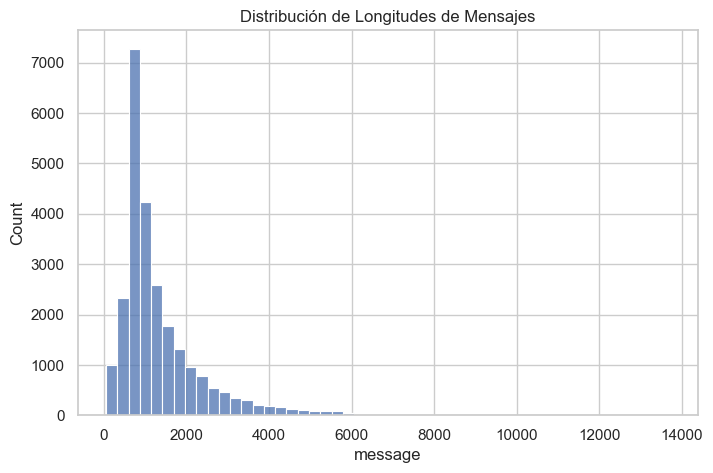

In [92]:
#graficar distribución de las longitudes de los mensajes
plt.figure(figsize=(8, 5))
sns.histplot(df_train['message'].apply(len), bins=50)
#set title
plt.title('Distribución de Longitudes de Mensajes')

prom_len = df_train['message'].apply(len).mean()
print(f'Promedio de longitud de mensajes: {prom_len}')


Text(0, 0.5, 'Frecuencia')

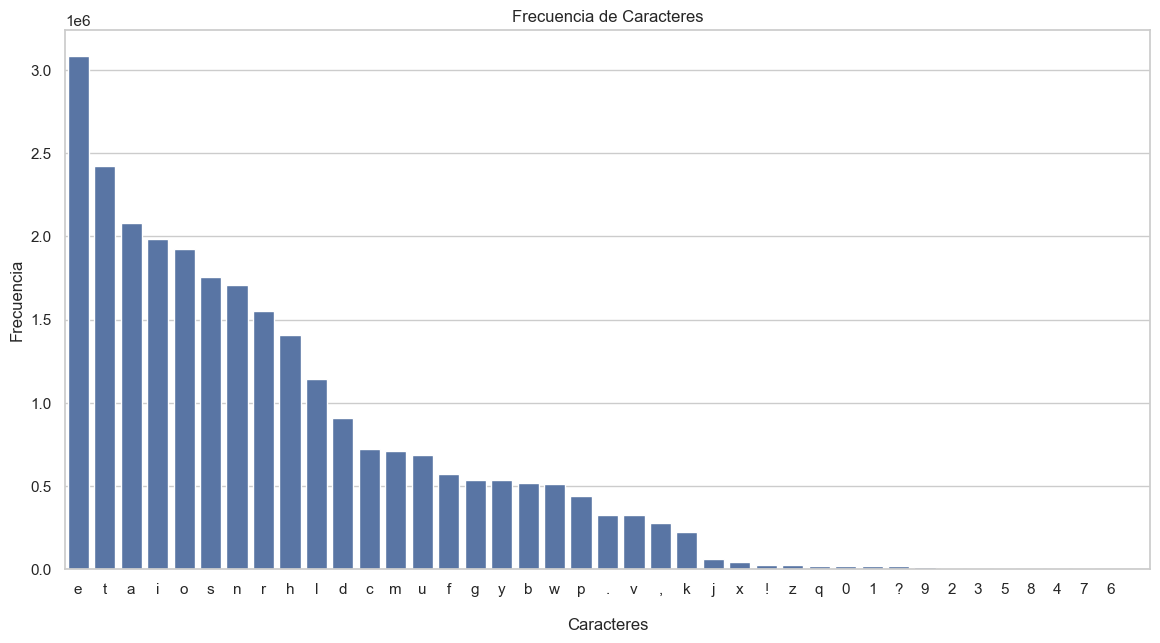

In [93]:
#graficar la frecuencia de cada caracter
dict_chars = { c : 0 for c in 'abcdefghijklmnopqrstuvwxyz!?.,0123456789\n'}
for message in df_train['message']:
    for c in message.lower():
        if c in dict_chars:
            dict_chars[c] += 1
            
            
#Oderdar de mayor a menor frecuencia
dict_chars = dict(sorted(dict_chars.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(14, 7))
sns.barplot(x=list(dict_chars.keys()), y=list(dict_chars.values()))
plt.title('Frecuencia de Caracteres')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')


In [94]:
#seleccionar los primeros k caracteres mas frecuentes
k = 28
alfabet_used = list(dict_chars.keys())[0:k]
print(f'Caracteres más frecuentes usados: {alfabet_used}')

Caracteres más frecuentes usados: ['e', 't', 'a', 'i', 'o', 's', 'n', 'r', 'h', 'l', 'd', 'c', 'm', 'u', 'f', 'g', 'y', 'b', 'w', 'p', '.', 'v', ',', 'k', 'j', 'x', '!', 'z']


### Extracción

In [95]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix


# Funciones auxiliares
def build_char_mat(quote, MAX_LEN, CHAR_DICT):
    # Usamos lil_matrix para la matriz dispersa
    char_mat = np.zeros((len(CHAR_DICT), MAX_LEN), dtype=np.float32)
    quote = quote.lower()
    for i, char in enumerate(quote):
        if i >= MAX_LEN:
            break
        if char in CHAR_DICT:
            char_mat[CHAR_DICT[char], i] = 1
    return char_mat

def generate_char_dict(string):
    char_dict = {}
    for char in string:
        if char not in char_dict:
            char_dict[char] = len(char_dict)
    return char_dict

def executeCQ(df, alfabet, MAX_LEN):
    CHAR_DICT = generate_char_dict(alfabet)
    results = []
    for row in df:
        # Remove special characters that are not in the alphabet
        msg = ''.join([char for char in row if char in CHAR_DICT])
        char_mat = torch.tensor(build_char_mat(msg, MAX_LEN, CHAR_DICT))
        results.append(char_mat)
    return torch.stack(results, dim=0)

In [96]:
from sklearn.model_selection import train_test_split
df_train_cq, df_test_cq = train_test_split(df_train, test_size=TEST_SIZE, random_state=P_SEED)
alfabet_dict = generate_char_dict(alfabet_used)

In [97]:
x_train_cq = executeCQ(df_train_cq['message'], alfabet_used, CQ_CHARS)
x_test_cq = executeCQ(df_test_cq['message'], alfabet_used, CQ_CHARS)
cq_n_features = x_train_cq.shape[2]
cq_n_chars = x_train_cq.shape[1]

print(f'Number of features: {cq_n_features}')
print(f'Number of characters: {cq_n_chars}')

Number of features: 1500
Number of characters: 28


In [98]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_cq = label_encoder.fit_transform(df_train_cq['label'])
y_test_cq = label_encoder.transform(df_test_cq['label'])

## WORD2VEC

### Eliminación de stop words 

In [99]:
import torch
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
alphabet_used = set("abcdefghijklmnopqrstuvwxyz ")


def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char in alphabet_used])
    words = text.split()
    words = [word for word in set(words) if word not in stop_words]
    return words

def build_df_words(df):
    #add new column
    d = df.copy()
    d['words'] = d['message'].apply(preprocess_text)
    return d

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_train_words, df_test_words = train_test_split(df_train, test_size=TEST_SIZE, random_state=P_SEED)

df_train_words = build_df_words(df_train_words)
df_test_words = build_df_words(df_test_words)

df_submit_words = build_df_words(df_submit)

Promedio de longitud de mensajes: 100.7556


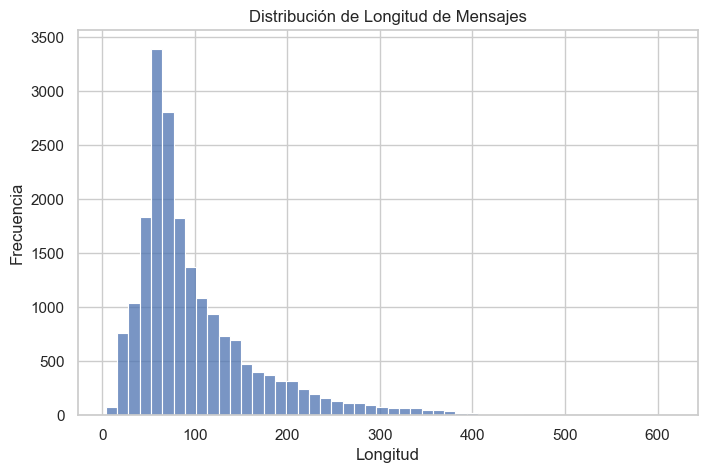

In [101]:
#graficar la distribución de la longitud de los mensajes
plt.figure(figsize=(8, 5))
sns.histplot(df_train_words['words'].apply(lambda x: len(set(x))), bins=50)
plt.title('Distribución de Longitud de Mensajes')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')

prom_len = df_train_words['words'].apply(lambda x: len(set(x))).mean()
print(f'Promedio de longitud de mensajes: {prom_len}')

### Cargar modelo preentrenado (word2vec-google-news-300)

In [102]:
#load numpy
import gensim.downloader as api

#load word2vec
word2vec = api.load('word2vec-google-news-300')

### Extraer vectores

In [103]:
#construir matrix
def build_embedding_matrix(df, word2vec_dict, max_words):
    result = np.zeros((len(df['words']), max_words, 300), dtype=np.float32)
    for i, words in enumerate(df['words']):
        emb = np.zeros((max_words,300), dtype=np.float32)
        count = 0
        for word in words:
            if count >= max_words:
                break
            if word in word2vec_dict:
                emb[count] = word2vec_dict[word]
                count += 1
        result[i] = emb
    return result

In [104]:
x_train_wd = build_embedding_matrix(df_train_words, word2vec, W2V_WORDS)
x_test_wd = build_embedding_matrix(df_test_words, word2vec, W2V_WORDS)
x_submit_wd = build_embedding_matrix(df_submit_words, word2vec, W2V_WORDS)

In [105]:
x_train_wd.shape

(20000, 150, 300)

In [106]:
wd_n_features = x_train_wd.shape[2]
print(f'Number of features: {wd_n_features}')

Number of features: 300


In [107]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_wd = label_encoder.fit_transform(df_train_words['label'])
y_test_wd = label_encoder.transform(df_test_words['label'])

----
# 3. Experimentación

## Funciones auxiliares

In [67]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [68]:
#funciones de experimentación
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def matriz_confusion(y_test, y_pred, Tipo):
 matrix = confusion_matrix(y_test, y_pred)
 f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index= label_encoder.classes_  , columns=label_encoder.classes_)
 sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
 plt.title("Confusion Matrix - "  + Tipo ), plt.tight_layout()
 plt.xlabel("Predicted")
 plt.ylabel("Real")
 plt.show()

# Write your code here
def test(model, loader, tipo):
  if tipo == "MLP" or tipo == "CNN":
    model.eval()
    #crear tensores de salida
    y_test = torch.tensor([], dtype=torch.long)
    y_pred = torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        for x_test_v, y_test_v in loader:
          x_test_v = x_test_v.to(device)
          y_test_v = y_test_v.to(device)
          y_pred_v = model(x_test_v)
    
          y_pred_v = torch.argmax(y_pred_v, dim=1).cpu()
          y_test_v = y_test_v.cpu()
          
          #agregar a las listas
          y_test = torch.cat((y_test, y_test_v), dim=0)
          y_pred = torch.cat((y_pred, y_pred_v), dim=0)
        torch.cuda.empty_cache()
  else:
    y_pred = model.predict(x_test)
    
  print("F",y_test)
  print("F",y_pred)

    
  print(classification_report(y_test, y_pred))
  matriz_confusion(y_test, y_pred,tipo)

In [69]:
def train(model, loss_f, optimizer, epochs, train_loader,name):
    loss_lista = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            loss = loss_f(y_pred, y_batch)
            epoch_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_lista.append(avg_epoch_loss)
        torch.save(model.state_dict(), f"models/{name}.pth")
        if epoch % 1 == 0:
            print('Epoch {}: train loss: {:.4f}'.format(epoch, avg_epoch_loss))
    return loss_lista

## SVM TEST

### SVM con TF-IDF

In [114]:
#%pip install umap-learn
#%pip install ipywidgets

  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.7 MB 8.9 MB/s eta 0:00:01
   -------- ------------------------------- 0.6/2.7 MB 5.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.7 MB 6.4 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.7 MB 5.3 MB/s eta 0:00:01
   ----------------- ---------------------- 1.2/2.7 MB 4.3 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.7 MB 4.4 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 MB 4.4 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.7 MB 4.3 MB/s eta 0:00:01
   ----------------------------- ---------- 2.0/2.7 MB 4.1 MB/s eta 0:00:01
   ------------------------------- -------- 2.1/2.7 MB 4.0 MB/s eta 0:00:01
   ----------------------------------- ---- 2.4/2.

In [125]:
#scaler
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
x_train_tf = scaler.fit_transform(x_train_chi2.toarray())
x_test_tf = scaler.transform(x_test_chi2.toarray())

#normalizar usando umap
import umap

reducer = umap.UMAP(n_components=3)
x_train_umap = reducer.fit_transform(x_train_tf)
x_test_umap = reducer.transform(x_test_tf)
x_submit_umap = reducer.transform(x_submit_tf)

f:\Tareas\Comp\Proyecto\Proy4-ML\.venv\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Text(0.5, 0.92, 'UMAP - W2V')

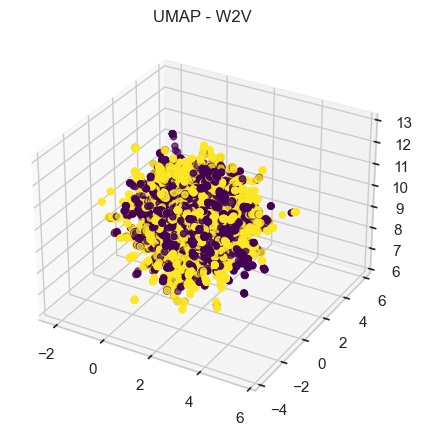

In [126]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_umap[:, 0], x_train_umap[:, 1], x_train_umap[:, 2], c=y_train_wd, cmap='viridis')
plt.title('UMAP - W2V')


In [65]:
from sklearn.svm import SVC
clfSVM = SVC()

clfSVM.fit(x_train_chi2, y_train_tf)

SVC()

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2463
           1       0.88      0.90      0.89      2537

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



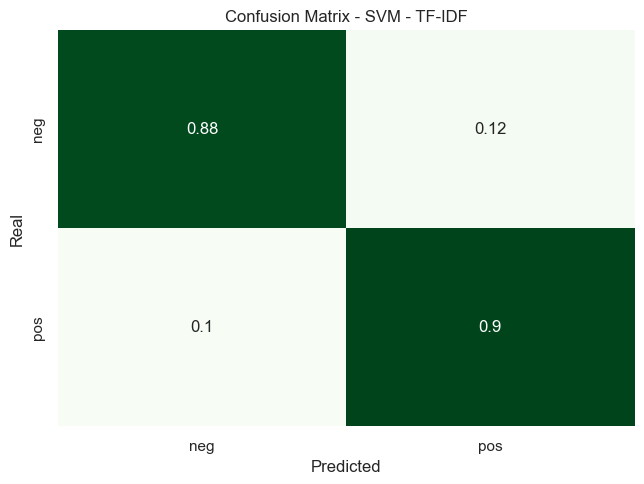

In [71]:
#testear
from sklearn.metrics import classification_report

y_pred_svc = clfSVM.predict(x_test_chi2)
print(classification_report(y_test_tf, y_pred_svc))
matriz_confusion(y_test_tf, y_pred_svc, "SVM - TF-IDF")

### SVM con WORD2VEC

In [ ]:
#scaler
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
x_train_tf = scaler.fit_transform(x_train_wd.sum(axis=1))
x_test_tf = scaler.transform(x_test_wd.sum(axis=1))

#normalizar usando umap
import umap

reducer = umap.UMAP(n_components=3)
x_train_umap = reducer.fit_transform(x_train_tf)
x_test_umap = reducer.transform(x_test_tf)

Text(0.5, 0.92, 'UMAP - W2V')

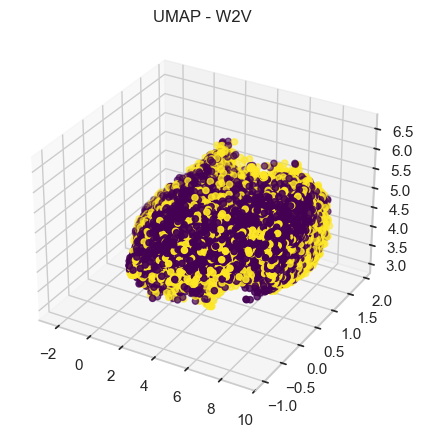

In [124]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_umap[:, 0], x_train_umap[:, 1], x_train_umap[:, 2], c=y_train_wd, cmap='viridis')
plt.title('UMAP - W2V')


In [121]:
# fast test with training with svm
from sklearn.svm import SVC
clfSVM_W2V = SVC()

clfSVM_W2V.fit(x_train_wd.sum(axis=1), y_train_wd)

SVC()

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2463
           1       0.86      0.86      0.86      2537

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



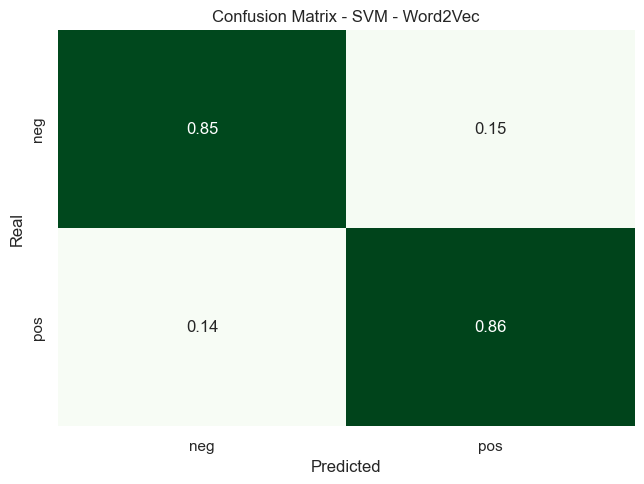

In [110]:
#testear
from sklearn.metrics import classification_report

y_pred_svc = clfSVM_W2V.predict(x_test_wd.sum(axis=1))
print(classification_report(y_test_wd, y_pred_svc))
matriz_confusion(y_test_wd, y_pred_svc, "SVM - Word2Vec")

## DT TEST

### DT con TF-IDF

In [86]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

clfDT = DecisionTreeClassifier()
clfDT.fit(x_train_chi2, y_train_tf)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2463
           1       0.73      0.70      0.71      2537

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



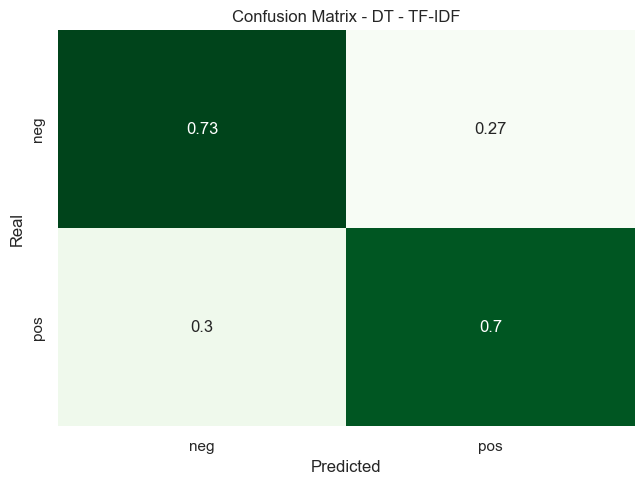

In [87]:
#testear
y_pred_dt = clfDT.predict(x_test_chi2)

print(classification_report(y_test_tf, y_pred_dt))
matriz_confusion(y_test_tf, y_pred_dt, "DT - TF-IDF")

### DT con WORD2VEC

In [111]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

clfDT = DecisionTreeClassifier()
clfDT.fit(x_train_chi2, y_train_tf)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2463
           1       0.73      0.71      0.72      2537

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



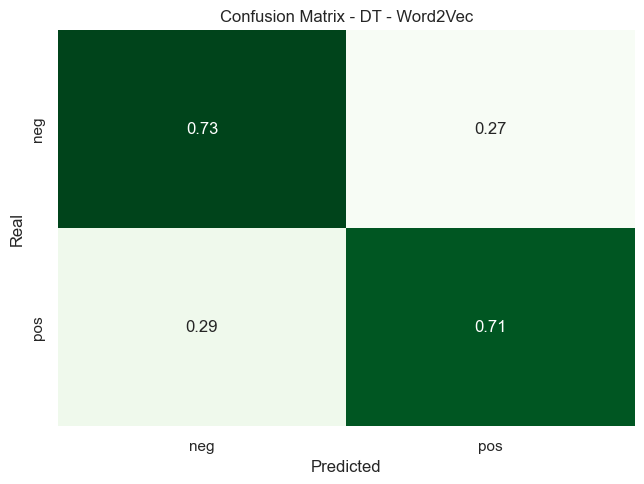

In [112]:
#testear
y_pred_dt = clfDT.predict(x_test_chi2)

print(classification_report(y_test_tf, y_pred_dt))
matriz_confusion(y_test_tf, y_pred_dt, "DT - Word2Vec")

## MLP TEST

In [128]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### MLP para TF-IDF

##### Arquitectura

In [145]:
from torch import nn

INPUT_SIZE = tf_n_features
OUTPUT_SIZE = 2
BATCH_SIZE = 32
LAYER_SIZE = 400

class MLP_TFIDF(nn.Module):
    def __init__(self):
        super(MLP_TFIDF, self).__init__()
        
        # Primera capa
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(LAYER_SIZE, OUTPUT_SIZE)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

##### Entrenamiento

In [146]:
import torch
# Modelos
model = MLP_TFIDF().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0075, weight_decay=1e-5)

In [147]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train_tf, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - TFIDF")
loss_list = train(model, loss, optimizer, 10, train_loader,"MLP_TDIF")

MLP TRAIN - TFIDF
Epoch 0: train loss: 0.3448
Epoch 1: train loss: 0.2206
Epoch 2: train loss: 0.1762
Epoch 3: train loss: 0.1362
Epoch 4: train loss: 0.1169
Epoch 5: train loss: 0.1002
Epoch 6: train loss: 0.0772
Epoch 7: train loss: 0.0791
Epoch 8: train loss: 0.0624
Epoch 9: train loss: 0.0638


##### Resultados

F tensor([1, 0, 1,  ..., 1, 1, 0])
F tensor([0, 0, 0,  ..., 1, 1, 0])
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2463
           1       0.89      0.85      0.87      2537

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



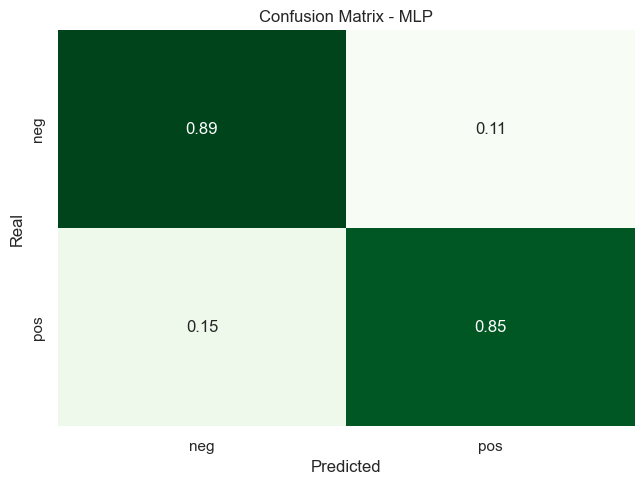

In [148]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
#Test 
x_test_dv = torch.tensor(x_test_chi2.toarray(), dtype=torch.float32)
y_test_dv = torch.tensor(y_test_tf, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

#### MLP para CQ

##### Arquitectura

In [150]:
from torch import nn

INPUT_SIZE = cq_n_features * cq_n_chars
OUTPUT_SIZE = 2
BATCH_SIZE = 32
LAYER_SIZE = 400

class MLP_CQ(nn.Module):
    def __init__(self):
        super(MLP_CQ, self).__init__()
        
        # Primera capa
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(LAYER_SIZE, OUTPUT_SIZE)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

##### Entrenamiento

In [151]:
import torch
# Modelos
model = MLP_CQ().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0075, weight_decay=1e-5)

In [153]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = x_train_cq.reshape(-1, INPUT_SIZE)
y_train_dv = torch.tensor(y_train_tf, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - CQ")
loss_list = train(model, loss, optimizer, 10, train_loader,"MLP_CQ")

MLP TRAIN - CQ
Epoch 0: train loss: 0.7308
Epoch 1: train loss: 0.6381
Epoch 2: train loss: 0.4607
Epoch 3: train loss: 0.3073
Epoch 4: train loss: 0.2232
Epoch 5: train loss: 0.1813
Epoch 6: train loss: 0.1525
Epoch 7: train loss: 0.1385
Epoch 8: train loss: 0.1285
Epoch 9: train loss: 0.1164


##### Resultados

F tensor([1, 0, 0,  ..., 0, 0, 0])
F tensor([0, 1, 0,  ..., 1, 0, 0])
              precision    recall  f1-score   support

           0       0.53      0.65      0.58      2463
           1       0.56      0.44      0.49      2537

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.54      0.54      5000



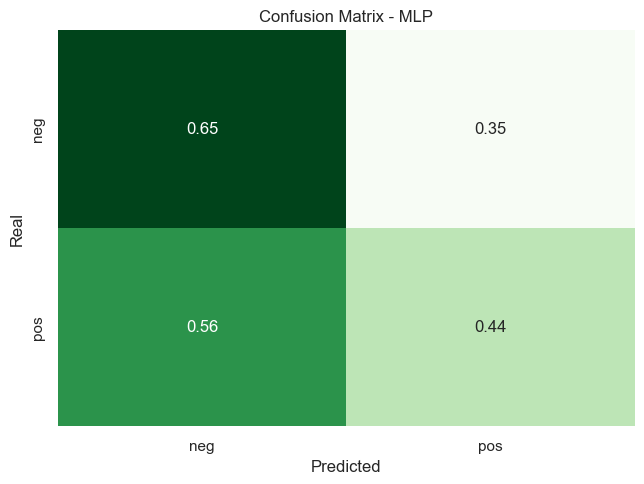

In [158]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
#Test 
x_test_dv = x_test_cq.reshape(-1, INPUT_SIZE)
y_test_dv = torch.tensor(y_test_cq, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

In [ ]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_wd, dtype=torch.float32)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = model(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

In [ ]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - TFIDF")
loss_list = train(model, loss, optimizer, 10, train_loader,"MLP_TDIF")

F tensor([1, 0, 0,  ..., 1, 1, 1])
F tensor([1, 1, 1,  ..., 1, 1, 1])
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2463
           1       0.88      0.86      0.87      2537

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



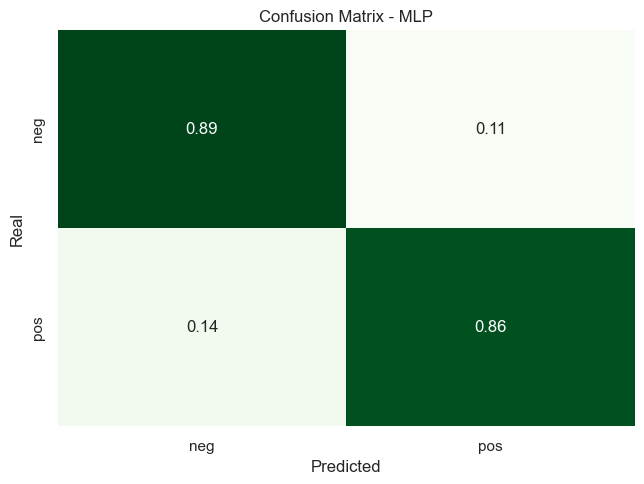

In [135]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
#Test 
x_test_dv = torch.tensor(x_test_chi2.toarray(), dtype=torch.float32)
y_test_dv = torch.tensor(y_test_tf, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

F tensor([0, 1, 0,  ..., 1, 0, 0])
F tensor([0, 1, 1,  ..., 1, 0, 1])
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2563
           1       0.75      0.81      0.78      2437

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



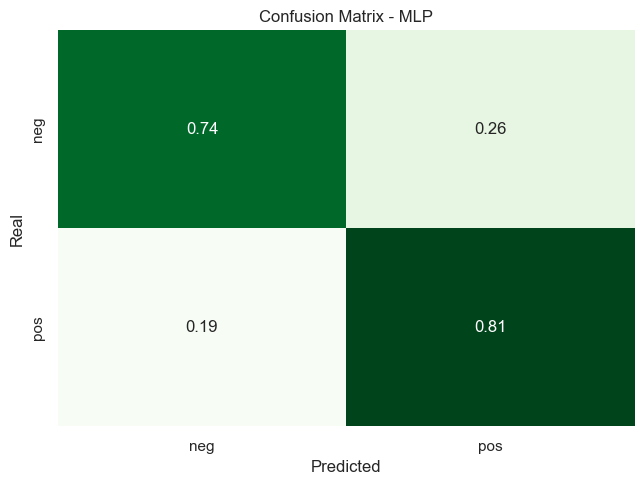

In [ ]:
x_test_dv = torch.tensor(x_test_wd, dtype=torch.float32)
y_test_dv = torch.tensor(y_test_wd, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

In [ ]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_wd, dtype=torch.float32)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = model(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

In [ ]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - TFIDF")
loss_list = train(model, loss, optimizer, 10, train_loader,"MLP_TDIF")

#### MLP para Word2Vec

##### Arquitectura

In [168]:
from torch import nn
INPUT_SIZE = x_train_wd.shape[2]
OUTPUT_SIZE = 2
BATCH_SIZE = 256
LAYER_SIZE = 10

#
class MLP_W2V(nn.Module):
    def __init__(self):
        super(MLP_W2V, self).__init__()
        
        # Primera capa
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(LAYER_SIZE, OUTPUT_SIZE)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

##### Entrenamiento

In [169]:
import torch
# Modelos
model = MLP_W2V().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0075, weight_decay=1e-5)

In [170]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_wd.sum(axis = 1), dtype=torch.float32)
print(x_train_dv.shape)

y_train_dv = torch.tensor(y_train_wd, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - W2V")
loss_list = train(model, loss, optimizer, 10, train_loader,"MLP_W2V")

torch.Size([20000, 300])
MLP TRAIN - W2V
Epoch 0: train loss: 0.6045
Epoch 1: train loss: 0.4968
Epoch 2: train loss: 0.4746
Epoch 3: train loss: 0.4627
Epoch 4: train loss: 0.4569
Epoch 5: train loss: 0.4528
Epoch 6: train loss: 0.4462
Epoch 7: train loss: 0.4371
Epoch 8: train loss: 0.4341
Epoch 9: train loss: 0.4291


##### Resultados

F tensor([1, 0, 0,  ..., 0, 1, 1])
F tensor([1, 0, 0,  ..., 0, 0, 1])
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2463
           1       0.89      0.81      0.84      2537

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



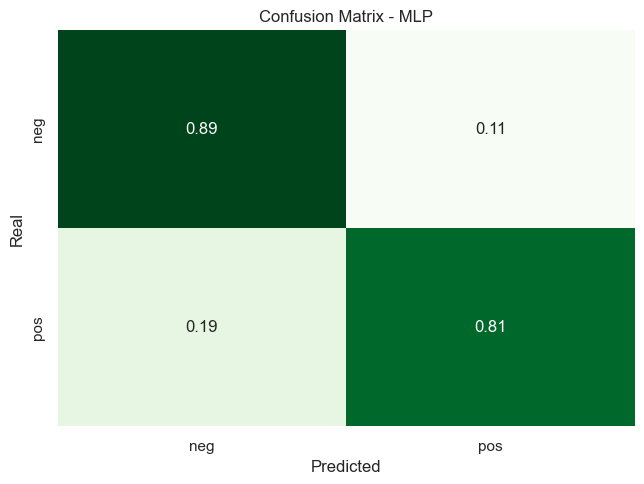

In [172]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
#Test 
x_test_dv = torch.tensor(x_test_wd.sum(axis = 1), dtype=torch.float32)
y_test_dv = torch.tensor(y_test_wd, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

## CNN TEST

In [ ]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Arquitectura

In [ ]:
x_train_wd.shape

(20000, 250, 300)

In [ ]:
#CNN
import torch.nn as nn

channels = x_train_wd.shape[1]
n_features = x_train_wd.shape[2]
#ALFABET_SIZE = n_chars
OUTPUT_SIZE = 2
DROPOUT_RATE = 0.4
BATCH_SIZE = 64

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layerConv = nn.Sequential(
            nn.Conv1d(in_channels=channels, out_channels=32, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
            )
    
        #obtain the size of the output of the convolutional layers
        output_size = self.layerConv(torch.rand(1, channels, n_features)).size()
        layerFC_input = output_size[1] * output_size[2]
        print(layerFC_input)
        self.layerFC = nn.Sequential(
            nn.Linear(layerFC_input, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(64, OUTPUT_SIZE))
        
    def forward(self, x):
        #print(x.size())
        out = self.layerConv(x)
        #print(out.size())
        out = out.reshape(out.size(0), -1)
        #print(out.size())
        out = self.layerFC(out)
        return out

#### Entrenamiento

In [ ]:
# Modelos
modelCNN = CNN().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.SGD(modelCNN.parameters(), lr = 0.01, weight_decay=1e-5)

4704


In [ ]:
#cargar si existe
modelCNN = CNN().to(device)
modelCNN.load_state_dict(torch.load('modelCNN.pth'))
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(modelCNN.parameters(), lr = 0.005,weight_decay=1e-5)

In [ ]:
x_train_dv = torch.tensor(x_train_chi2.todense(), dtype=torch.float32)
x_train_dv = x_train_dv.reshape(-1, 1, QUOTE_SIZE)

y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("CNN TRAIN")
loss_list = train(modelCNN, loss, optimizer, 10, train_loader,"modelCNN")

In [ ]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_train_dv = x_train_cq
#x_train_dv = x_train_dv.reshape(-1, 1, x_train_cq[0].shape[0], x_train_cq[0].shape[1])

print(x_train_dv.shape)
y_train_dv = torch.tensor(y_train_cq, dtype=torch.long)

train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("CNN TRAIN")
loss_list = train(modelCNN, loss, optimizer, 10, train_loader,"modelCNN_RT")

In [ ]:
x_train_dv = torch.tensor(x_train_wd, dtype=torch.float32)
y_train_dv = torch.tensor(y_train_wd, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("CNN TRAIN")
loss_list = train(modelCNN, loss, optimizer, 5, train_loader,"modelCNN_WD")

CNN TRAIN
Epoch 0: train loss: 0.5658
Epoch 1: train loss: 0.3788
Epoch 2: train loss: 0.2936
Epoch 3: train loss: 0.2249
Epoch 4: train loss: 0.1704


#### Resultados

F tensor([1, 0, 0,  ..., 1, 0, 1])
F tensor([1, 1, 1,  ..., 1, 1, 1])
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      2563
           1       0.74      0.89      0.80      2437

    accuracy                           0.79      5000
   macro avg       0.80      0.79      0.79      5000
weighted avg       0.80      0.79      0.79      5000



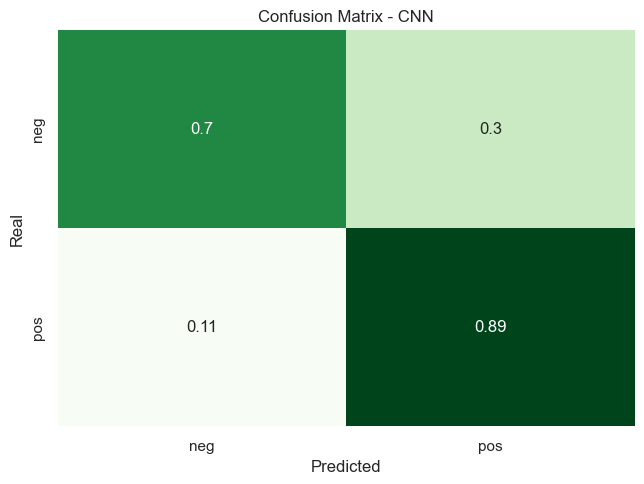

In [ ]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_test_dv = torch.tensor(x_test_wd, dtype=torch.float32)
y_test_dv = torch.tensor(y_test_wd, dtype=torch.long)
test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(modelCNN, test_loader, "CNN")

In [ ]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_chi2.toarray(), dtype=torch.float32)
x_submit_t = x_submit_t.reshape(-1, 1, n_features)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
modelCNN.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = modelCNN(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

## LSTM

----
# MISC



In [119]:
#clear memory
import gc
import torch

gc.collect()            # Llama al recolector de basura para liberar memoria
torch.cuda.empty_cache()  # Limpia la memoria de GPU

In [19]:
#DO NOT EXECUTE: Clear all variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
        
del name